In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

from emd import emd
from kde.location_project.cmp import geodesic_dist
# from kde.location_project.kde_2d import kdnearest

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
time_span = 'month'
n_visits = 1

# Geolocation Data - Twitter

NOTE: all of the results in the paper discussed B as fixed, but in this analysis A is fixed.

In [2]:
### NY
ny_directory = os.path.join("..", "data", "ny") 
ny = pd.read_csv(os.path.join(ny_directory, "visits_no_filter.csv"))
ny_deduped = pd.read_csv(os.path.join(ny_directory, "visits_deduped.csv"))
mpp = pd.read_csv(os.path.join(ny_directory, "mpp_visits_month0a_month1b_n1.csv"))

print("Days:", ny['day_id'].nunique())
print("Accounts:", ny['user_id'].nunique())
print("Events: ", ny.shape[0], " (", round(ny.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("Visits: ", ny_deduped.shape[0], " (", round(ny_deduped.shape[0] / ny['user_id'].nunique(), 1), ")",sep="")
print("")
print("MPP DATA (at least {} visits in each of the first two {}s)".format(n_visits, time_span))
print("Users:", mpp['uid'].nunique())
print("Visits: ", len(mpp), " (", round(len(mpp) / mpp['uid'].nunique(), 1), ")",sep="")
ind_A = mpp.m == 'a'
print("n_A: ", len(mpp.loc[ind_A]), " (", round(len(mpp.loc[ind_A]) / mpp['uid'].nunique(), 1), ")",sep="")
ind_B = mpp.m == 'b'
print("n_B: ", len(mpp.loc[ind_B]), " (", round(len(mpp.loc[ind_B]) / mpp['uid'].nunique(), 1), ")",sep="")


Days: 239
Accounts: 194224
Events: 1162871 (6.0)
Visits: 989494 (5.1)

MPP DATA (at least 1 visits in each of the first two months)
Users: 13523
Visits: 138651 (10.3)
n_A: 72799 (5.4)
n_B: 65852 (4.9)


In [3]:
# location weights based on number of visits
ny_locs = ny_deduped.groupby('location_id')['event_id'].count()
ny_wt_e = pd.DataFrame(ny_locs).reset_index().rename(columns={'event_id': 'weight'})
ny_wt_e['weight'] = 1 / ny_wt_e['weight']

# location weights based on number of unique users at lnyation
ny_locs_users = ny_deduped.groupby(['location_id'])['old_uid'].nunique()
ny_wt_u = pd.DataFrame(ny_locs_users).reset_index().rename(columns={'old_uid': 'weight'})
ny_wt_u['weight'] = 1 / ny_wt_u['weight']

# merge weights in to the point pattern data
ny_deduped = pd.merge(ny_deduped, ny_wt_e, on='location_id')
ny_deduped = pd.merge(ny_deduped, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
ny_deduped.head()

,old_uid,uid,lon,lat,location_id,visit,month,event_id,weight_event,weight_user
0,22.0,-1.0,-73.99706,40.73597,23615.0,0,6,6101502.0,0.003378,0.004587
1,8881.0,-1.0,-73.99706,40.73597,23615.0,0,4,2173506.0,0.003378,0.004587
2,705663.0,-1.0,-73.99706,40.73597,23615.0,0,0,11273583.0,0.003378,0.004587
3,754812.0,-1.0,-73.99706,40.73597,23615.0,0,4,5511985.0,0.003378,0.004587
4,1938691.0,-1.0,-73.99706,40.73597,23615.0,26,5,7998685.0,0.003378,0.004587


In [4]:
# merge weights in to the point pattern data
mpp = pd.merge(mpp, ny_wt_e, on='location_id')
mpp = pd.merge(mpp, ny_wt_u, on='location_id', suffixes=('_event', '_user'))
mpp.head()

,old_uid,uid,m,lon,lat,location_id,weight_event,weight_user
0,418.0,1,a,-73.99384,40.72405,4962.0,0.003774,0.004237
1,418.0,1,a,-73.99384,40.72405,4962.0,0.003774,0.004237
2,418.0,1,b,-73.99384,40.72405,4962.0,0.003774,0.004237
3,418.0,1,b,-73.99384,40.72405,4962.0,0.003774,0.004237
4,15455345.0,754,b,-73.99383,40.72408,4962.0,0.003774,0.004237


# Create necessary data for experiments

## Population KDE

In [5]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
    learn_nearest_neighbors_bandwidth
)

# learn the bandwidth for each point & save to file (it's expensive)
filepath = os.path.join("..", "data", "DFRWS_USA", "ny", "population_visits_kde_data.npy")

# points = ny_deduped.loc[:, ['lon', 'lat']].values
# bw_pop = learn_nearest_neighbors_bandwidth(points, k=5, min_bw=0.05)
# kde_data = np.hstack([points, np.atleast_2d(bw_pop).T])  # adaptive bandwidth
# kde_data = np.append(kde_data, np.ones((len(kde_data), 1)), 1)  # equal weights by default
# np.save(filepath, kde_data)

pop_kde_data = np.load(filepath)
pop_kde_data.shape

(989494, 4)

## Stratified Sample

In [6]:
# import itertools 
# np.random.seed(1234)
# splits = [1, 2, 20, float("inf")]

# # create all pairwise combinations
# ids = mpp.uid.unique()
# samp_space = pd.DataFrame(itertools.product(ids, ids), columns=["a", "b"])

# # merge in counts of events in A
# cts = mpp.groupby(['uid', 'm']).count().reset_index()
# cts = cts.loc[cts.m == 'a', ]
# cts = cts.rename(columns={"old_uid": "n_a"})
# cts.n_a.describe()
# samp_space = pd.merge(samp_space, cts[['uid', 'n_a']], left_on='a', right_on='uid').drop(columns="uid")

# # merge in counts of events in B
# cts = mpp.groupby(['uid', 'm']).count().reset_index()
# cts = cts.loc[cts.m == 'b', ]
# cts = cts.rename(columns={"old_uid": "n_b"})
# cts.n_b.describe()
# samp_space = pd.merge(samp_space, cts[['uid', 'n_b']], left_on='b', right_on='uid').drop(columns="uid")

# # bin the number of events in A and B for stratified sampling
# samp_space['bin_a'] = pd.cut(samp_space.n_a, bins=splits, right=False)
# samp_space['bin_b'] = pd.cut(samp_space.n_b, bins=splits, right=False)

# # sample 1000 pairs per combination of bins
# sample = samp_space.loc[samp_space.a != samp_space.b,].groupby(['bin_a', 'bin_b']).apply(lambda x: x.sample(1000))
# sample.index = sample.index.droplevel(0)
# sample.index = sample.index.droplevel(0)

# # add in same-source pairs
# sample = pd.concat([samp_space.loc[samp_space.a == samp_space.b,], sample], sort=True).reset_index(drop=True)

# # sample properties
# sample.groupby(['bin_a', 'bin_b'])['a'].count()


## Score function values for the sample

In [7]:
# from emd import emd
# from kde.location_project.cmp import geodesic_dist


# def get_user(mpp, uid, mark):
#     out = mpp.copy()
#     # out = out.drop_duplicates(subset=["location_id", "m"])
#     return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


# def population_scores(mpp, keeps):
#     rslt = []    
#     for index, row in keeps.iterrows():
#         user_A = row["a"]
#         user_B = row["b"]
#         tmp = {}
#         try:
#             ### get the data for the pair in question
#             tmp['a'] = user_A
#             tmp['b'] = user_B
#             uA = get_user(mpp, user_A, 'a')
#             uB = get_user(mpp, user_B, 'b')

#             ### compute weights
#             uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
#             uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
#             uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
#             uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

#             ### compute the distance matrix & IED scores
#             dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
#             ied = dist.min(1)
#             tmp['ied_med'] = np.median(ied)
#             tmp['ied_mn'] = np.average(ied)
#             tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
#             tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

#             ### compute variants of EMD
#             tmp['emd'] = emd(distance="precomputed", D=dist)
#             tmp['emd_wt_event'] = emd(
#                 X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
#             )
#             tmp['emd_wt_user'] = emd(
#                 X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
#             )

#             ### store it
#             rslt.append(tmp)
#         except:
#             print(f"Error! A = {user_A}, B = {user_B}")
#             continue
#     return pd.DataFrame(rslt)

# directory = os.path.join("..", "data", "DFRWS_USA", "ny")
# ny_rslt = population_scores(mpp, sample)
# ny_rslt.to_csv(os.path.join(directory, "score_func_vals.csv"), index=False)

In [8]:
directory = os.path.join("..", "data", "DFRWS_USA", "ny")
ny_rslt = pd.read_csv(os.path.join(directory, "score_func_vals.csv"))
ny_rslt

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user
0,1,1,1.073439,3.514420,2.282388,1.890170,3.639262,2.511669,2.309186
1,754,754,0.000000,0.082594,0.012435,0.001714,10.621138,2.701960,0.217977
2,914,914,1.285994,1.170474,1.296949,1.307994,1.894247,4.340711,4.323836
3,963,963,0.304149,0.457392,0.664379,0.690030,1.756811,1.373963,1.453024
4,1398,1398,0.001395,0.294026,0.083932,0.069981,0.294026,0.083932,0.069981
...,...,...,...,...,...,...,...,...,...
22518,4060,9441,1.161314,0.959781,1.088293,1.115413,3.246198,2.830677,2.978483
22519,7534,11463,15.644413,12.690486,12.911996,14.391071,15.195952,16.323192,17.836107
22520,10051,2784,3.571658,2.659750,2.241595,2.339622,3.095235,2.742689,2.757518
22521,13401,6021,1.342960,1.293657,1.182785,1.233621,3.147209,2.573242,3.251477


# Analyze Results

In [9]:
from sklearn.metrics import roc_auc_score

def perf_measure(y_actual, y_hat):
    y_actual = list(y_actual)
    y_hat = list(y_hat)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return (format(round(tpr, 3), '.3f'), format(round(fpr, 3), '.3f'))


def calc_auc(rslt, score, column='label'):
    return format(round(roc_auc_score(rslt[column], rslt[score]), 3), '.3f')


def slr_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\\\")
    print("\\hline")
    print(
        "& $\mean{D}_{min}$ & Uniform & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn'] > 1)), "&", 
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& $\mean{D}_{min}$ & Account  & ",
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_user'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& $\mean{D}_{min}$ & Visit    & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['ied_mn_wt_event'] > 1)), "&", 
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& EMD & Uniform & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd'] > 1)), "&", 
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD  & Account & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_user'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& EMD  & Visit  & ", 
        "{0[0]} & {0[1]}".format(perf_measure(rslt['label'], rslt['emd_wt_event'] > 1)), "&", 
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

    

def cmp_classifier_performance_for_tex(rslt):
    print("& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    ")
    print("\\hline")
    print(
        "& $\mean{D}_{min}$ & Uniform  & ", 
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn'), "\\\\"
    ) 
    print(
        "& $\mean{D}_{min}$ & Account & ",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_user'), "\\\\"
    )
    print(
        "& $\mean{D}_{min}$ & Visit & ", 
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['ied_mn_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'ied_mn_wt_event'), "\\\\"
    )
    print(
        "& EMD & Uniform & ", 
        perf_measure(~rslt['label'], rslt['emd'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd'), "\\\\"
    )
    print(
        "& EMD & Account & ",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_user'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_user'), "\\\\"
    )
    print(
        "& EMD & Visit & ", 
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.05)[0], "  &",
        perf_measure(~rslt['label'], rslt['emd_wt_event'] < 0.01)[0], "  &",
        calc_auc(rslt,'emd_wt_event'), "\\\\"
    )

In [10]:
directory = os.path.join("..", "data", "DFRWS_USA", "ny")
slr = pd.read_csv(os.path.join(directory, "slr.csv"))
cmp = pd.read_csv(os.path.join(directory, "cmp.csv"))
lr = pd.read_csv(os.path.join(directory, "lr.csv"))

slr["same-src"] = (slr.a == slr.b).astype(bool)
cmp["same-src"] = (cmp.a == cmp.b).astype(bool)
lr["same-src"] = (lr.a == lr.b).astype(bool)

In [11]:
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_vary'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_vary', 'same-src'))

TP/FP@1 ('0.285', '0.090')
AUC 0.768


In [12]:
print("TP/FP@1", perf_measure(lr['same-src'], lr['lr_alpha_80'] >= 0))
print("AUC", calc_auc(lr, 'lr_alpha_80', 'same-src'))

TP/FP@1 ('0.251', '0.067')
AUC 0.712


In [13]:
slr['label'] = (slr.a == slr.b).astype(bool)
slr_classifier_performance_for_tex(slr)

& $\Delta$ & Weights &  TP@1  & FP@1  & AUC \\
\hline
& $\mean{D}_{min}$ & Uniform &  0.508 & 0.287 & 0.656 \\
& $\mean{D}_{min}$ & Account  &  0.494 & 0.254 & 0.666 \\
& $\mean{D}_{min}$ & Visit    &  0.493 & 0.257 & 0.663 \\
& EMD & Uniform &  0.530 & 0.253 & 0.686 \\
& EMD  & Account &  0.511 & 0.235 & 0.685 \\
& EMD  & Visit  &  0.504 & 0.234 & 0.679 \\


In [14]:
cmp['label'] = (cmp.a != cmp.b).astype(bool)
cmp_classifier_performance_for_tex(cmp)

& $\Delta$ & Weights & TP@0.05  & TP@0.01 & AUC    
\hline
& $\mean{D}_{min}$ & Uniform  &  0.242   & 0.153   & 0.656 \\
& $\mean{D}_{min}$ & Account &  0.269   & 0.186   & 0.667 \\
& $\mean{D}_{min}$ & Visit &  0.264   & 0.179   & 0.665 \\
& EMD & Uniform &  0.265   & 0.139   & 0.687 \\
& EMD & Account &  0.283   & 0.161   & 0.686 \\
& EMD & Visit &  0.276   & 0.156   & 0.681 \\


## Accuracy by bin

In [15]:
# get counts of events in A & B
cts = mpp.groupby(['uid', 'm']).count().reset_index()

cts_a = cts.loc[cts.m == 'a', ]
cts_a = cts_a.rename(columns={"old_uid": "n_a"})
cts_a = cts_a[['uid', 'n_a']]

cts_b = cts.loc[cts.m == 'b', ]
cts_b = cts_b.rename(columns={"old_uid": "n_b"})
cts_b = cts_b[['uid', 'n_b']]

### LR Methods

In [16]:
# merge & bin counts
lr = pd.merge(lr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
lr = pd.merge(lr, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
lr['bin_a'] = pd.cut(lr.n_a, bins=splits, right=False)
lr['bin_b'] = pd.cut(lr.n_b, bins=splits, right=False)

In [17]:
lr.groupby(['bin_a', 'bin_b'])['a'].count()

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     3421
             [2.0, 20.0)    3060
             [20.0, inf)    1013
[2.0, 20.0)  [1.0, 2.0)     3567
             [2.0, 20.0)    6816
             [20.0, inf)    1156
[20.0, inf)  [1.0, 2.0)     1021
             [2.0, 20.0)    1218
             [20.0, inf)    1251
Name: a, dtype: int64

In [18]:
score_func = "lr_alpha_vary"
lr.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'same-src'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.601
             [2.0, 20.0)    0.656
             [20.0, inf)    0.757
[2.0, 20.0)  [1.0, 2.0)     0.643
             [2.0, 20.0)    0.639
             [20.0, inf)    0.718
[20.0, inf)  [1.0, 2.0)     0.814
             [2.0, 20.0)    0.825
             [20.0, inf)    0.972
dtype: object

In [19]:
lr.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] > 0))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.264, 0.141)
             [2.0, 20.0)    (0.340, 0.188)
             [20.0, inf)    (0.538, 0.158)
[2.0, 20.0)  [1.0, 2.0)     (0.183, 0.059)
             [2.0, 20.0)    (0.271, 0.053)
             [20.0, inf)    (0.564, 0.063)
[20.0, inf)  [1.0, 2.0)     (0.571, 0.065)
             [2.0, 20.0)    (0.679, 0.038)
             [20.0, inf)    (0.884, 0.043)
dtype: object

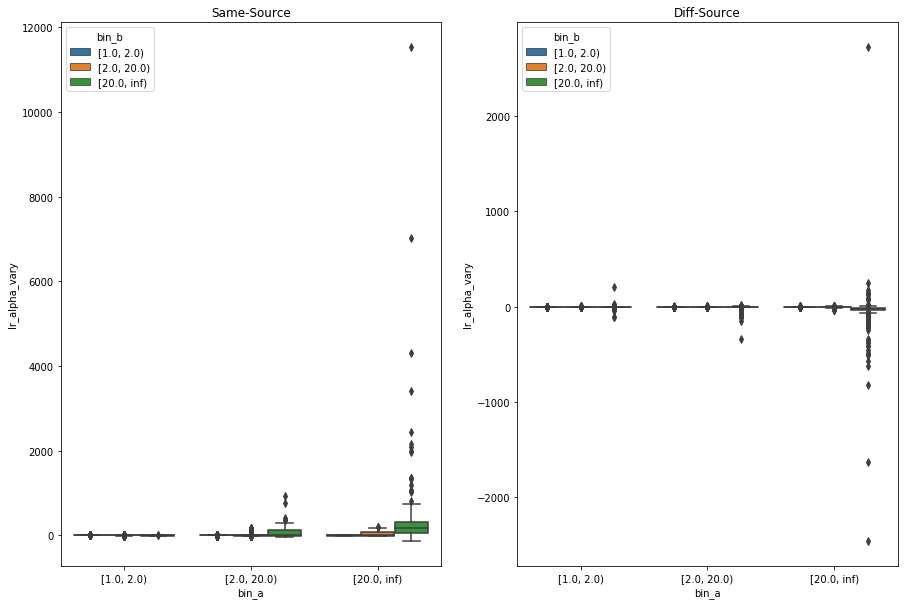

In [20]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=lr.loc[lr["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=lr.loc[lr["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()


### SLR Methods

In [21]:
# merge & bin counts
slr = pd.merge(slr, cts_a, left_on="a", right_on="uid").drop(columns="uid")
slr = pd.merge(slr, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
slr['bin_a'] = pd.cut(slr.n_a, bins=splits, right=False)
slr['bin_b'] = pd.cut(slr.n_b, bins=splits, right=False)

In [22]:
score_func = 'emd_wt_user'
slr.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'same-src'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.623
             [2.0, 20.0)    0.625
             [20.0, inf)    0.750
[2.0, 20.0)  [1.0, 2.0)     0.637
             [2.0, 20.0)    0.681
             [20.0, inf)    0.807
[20.0, inf)  [1.0, 2.0)     0.685
             [2.0, 20.0)    0.812
             [20.0, inf)    0.882
dtype: object

In [23]:
slr.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] > 1))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.484, 0.299)
             [2.0, 20.0)    (0.457, 0.266)
             [20.0, inf)    (0.462, 0.220)
[2.0, 20.0)  [1.0, 2.0)     (0.466, 0.266)
             [2.0, 20.0)    (0.540, 0.260)
             [20.0, inf)    (0.609, 0.197)
[20.0, inf)  [1.0, 2.0)     (0.429, 0.223)
             [2.0, 20.0)    (0.702, 0.215)
             [20.0, inf)    (0.801, 0.173)
dtype: object

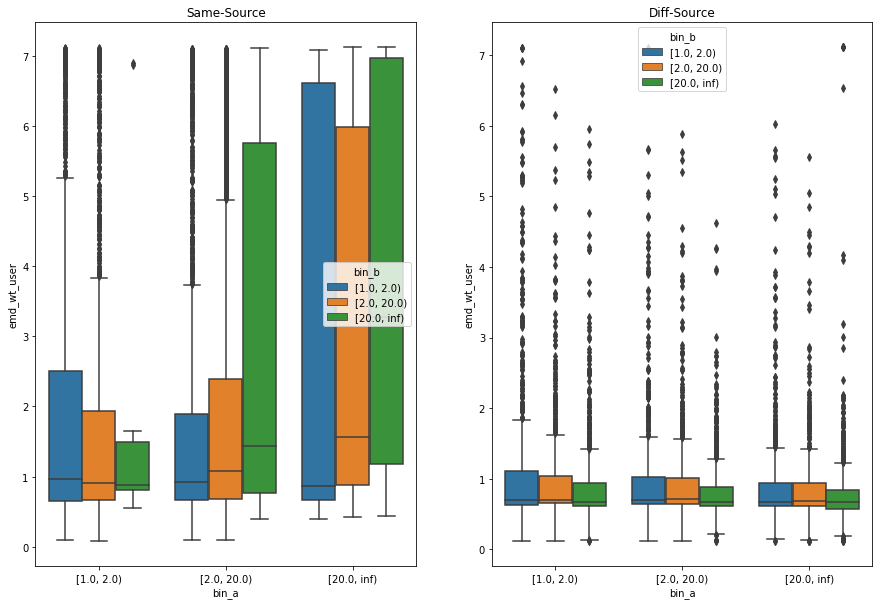

In [24]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=slr.loc[slr["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=slr.loc[slr["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()

### CMP Methods

In [25]:
# merge & bin counts
cmp = pd.merge(cmp, cts_a, left_on="a", right_on="uid").drop(columns="uid")
cmp = pd.merge(cmp, cts_b, left_on="b", right_on="uid").drop(columns="uid")

splits = [1, 2, 20, float("inf")]
cmp['bin_a'] = pd.cut(cmp.n_a, bins=splits, right=False)
cmp['bin_b'] = pd.cut(cmp.n_b, bins=splits, right=False)

cmp.head()

,a,b,ied_med,ied_mn,ied_mn_wt_event,ied_mn_wt_user,emd,emd_wt_event,emd_wt_user,same-src,label,n_a,n_b,bin_a,bin_b
0,1.0,1.0,0.225000,0.674222,0.486778,0.406000,0.550111,0.332444,0.287333,True,False,13,9,"[2.0, 20.0)","[2.0, 20.0)"
1,2.0,2.0,0.540000,0.519333,0.767667,0.764333,0.412556,0.704556,0.700889,True,False,2,7,"[2.0, 20.0)","[2.0, 20.0)"
2,3.0,3.0,0.057556,0.045889,0.009444,0.007000,0.080000,0.007889,0.006333,True,False,2,4,"[2.0, 20.0)","[2.0, 20.0)"
3,4.0,4.0,0.496999,0.535452,0.535341,0.531674,0.410980,0.379862,0.369749,True,False,3,2,"[2.0, 20.0)","[2.0, 20.0)"
4,13098.0,4.0,0.382219,0.356626,0.408145,0.381996,0.268165,0.511183,0.249360,False,True,27,2,"[20.0, inf)","[2.0, 20.0)"


In [26]:
score_func = 'emd_wt_user'
cmp.groupby(['bin_a', 'bin_b']).apply(lambda x: calc_auc(x, score_func, 'label'))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     0.624
             [2.0, 20.0)    0.626
             [20.0, inf)    0.753
[2.0, 20.0)  [1.0, 2.0)     0.637
             [2.0, 20.0)    0.683
             [20.0, inf)    0.808
[20.0, inf)  [1.0, 2.0)     0.677
             [2.0, 20.0)    0.812
             [20.0, inf)    0.884
dtype: object

In [27]:
cmp.groupby(['bin_a', 'bin_b']).apply(lambda x: perf_measure(x['same-src'], x[score_func] < 0.05))

bin_a        bin_b      
[1.0, 2.0)   [1.0, 2.0)     (0.287, 0.107)
             [2.0, 20.0)    (0.248, 0.067)
             [20.0, inf)    (0.154, 0.047)
[2.0, 20.0)  [1.0, 2.0)     (0.242, 0.060)
             [2.0, 20.0)    (0.288, 0.046)
             [20.0, inf)    (0.417, 0.028)
[20.0, inf)  [1.0, 2.0)     (0.333, 0.044)
             [2.0, 20.0)    (0.450, 0.032)
             [20.0, inf)    (0.610, 0.020)
dtype: object

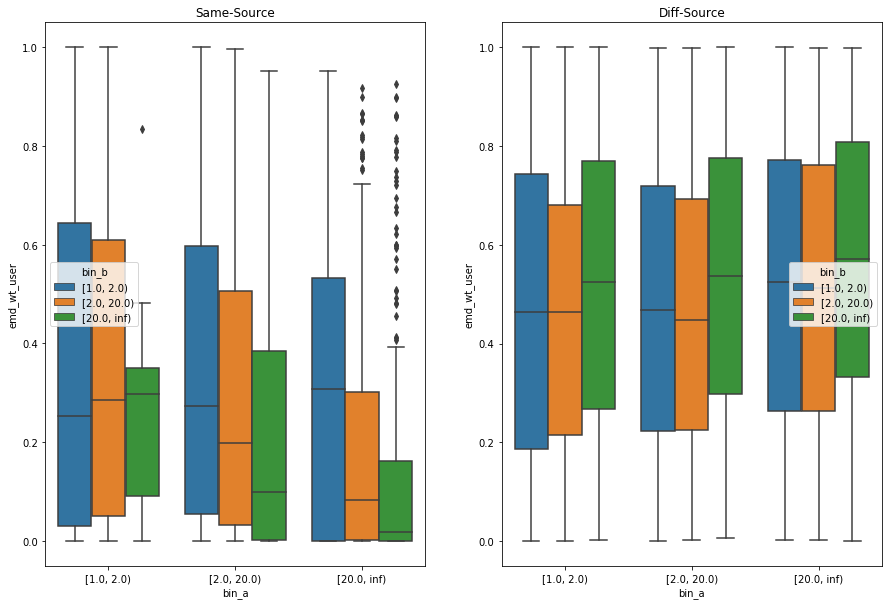

In [28]:
f, axes = plt.subplots(1, 2, figsize=(15,10))
sns.boxplot(y=score_func, x="bin_a", data=cmp.loc[cmp["same-src"] == True], hue="bin_b", ax=axes[0]).set_title("Same-Source")
sns.boxplot(y=score_func, x="bin_a", data=cmp.loc[cmp["same-src"] == False], hue="bin_b", ax=axes[1]).set_title("Diff-Source")
plt.show()

# Plot TP & FP rates for the different methods binned by `n_A` & `n_B`

### Create the data set

In [29]:
def performance_stats(x, score_func, column, criteria):
    out = []
    for s in score_func:
        d = {}
        d['score'] = s
        d['auc'] = calc_auc(x, s, column)
        d['tp'], d['fp'] = perf_measure(x[column], x[s] > criteria)
        out.append(d)
    return pd.DataFrame(out)

lr_rslt = lr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, ['lr_alpha_vary', 'lr_alpha_80'], 'same-src', 0) 
).reset_index()
lr_rslt['method'] = 'lr'
lr_rslt.drop(columns='level_2', inplace=True)
lr_rslt.head()


,bin_a,bin_b,score,auc,tp,fp,method
0,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_vary,0.601,0.264,0.141,lr
1,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_80,0.602,0.264,0.141,lr
2,"[1.0, 2.0)","[2.0, 20.0)",lr_alpha_vary,0.656,0.340,0.188,lr
3,"[1.0, 2.0)","[2.0, 20.0)",lr_alpha_80,0.663,0.237,0.103,lr
4,"[1.0, 2.0)","[20.0, inf)",lr_alpha_vary,0.757,0.538,0.158,lr


In [30]:
scores = ['ied_mn', 'ied_mn_wt_event', 'ied_mn_wt_user', 'emd', 'emd_wt_event', 'emd_wt_user']

slr_rslt = slr.groupby(['bin_a', 'bin_b']).apply(
    lambda x: performance_stats(x, scores, 'same-src', 1) 
).reset_index()
slr_rslt['method'] = 'slr'
slr_rslt.drop(columns='level_2', inplace=True)
slr_rslt.head()


,bin_a,bin_b,score,auc,tp,fp,method
0,"[1.0, 2.0)","[1.0, 2.0)",ied_mn,0.623,0.371,0.185,slr
1,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_event,0.622,0.348,0.151,slr
2,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_user,0.622,0.347,0.150,slr
3,"[1.0, 2.0)","[1.0, 2.0)",emd,0.624,0.506,0.328,slr
4,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_event,0.623,0.483,0.297,slr


In [31]:
def cmp_performance_stats(x, score_func, criteria):
    out = []
    for s in score_func:
        d = {}
        d['score'] = s
        d['auc'] = calc_auc(x, s, 'label')
        d['tp'], d['fp'] = perf_measure(x['same-src'], x[s] < criteria)
        out.append(d)
    return pd.DataFrame(out)

cmp_rslt = cmp.groupby(['bin_a', 'bin_b']).apply(
    lambda x: cmp_performance_stats(x, scores, 0.05) 
).reset_index()
cmp_rslt['method'] = 'cmp'
cmp_rslt.drop(columns='level_2', inplace=True)
cmp_rslt.head()


,bin_a,bin_b,score,auc,tp,fp,method
0,"[1.0, 2.0)","[1.0, 2.0)",ied_mn,0.624,0.194,0.038,cmp
1,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_event,0.624,0.190,0.037,cmp
2,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_user,0.624,0.190,0.037,cmp
3,"[1.0, 2.0)","[1.0, 2.0)",emd,0.624,0.314,0.120,cmp
4,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_event,0.624,0.290,0.108,cmp


In [32]:
# combine them
rslt = pd.concat([lr_rslt, slr_rslt, cmp_rslt], ignore_index=True)
rslt = rslt.sort_values(by=['bin_a', 'bin_b', 'method', 'score'])
rslt = rslt.astype({'auc': float, 'tp': float, 'fp': float})
rslt.head()

,bin_a,bin_b,score,auc,tp,fp,method
75,"[1.0, 2.0)","[1.0, 2.0)",emd,0.624,0.314,0.120,cmp
76,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_event,0.624,0.290,0.108,cmp
77,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.624,0.287,0.107,cmp
72,"[1.0, 2.0)","[1.0, 2.0)",ied_mn,0.624,0.194,0.038,cmp
73,"[1.0, 2.0)","[1.0, 2.0)",ied_mn_wt_event,0.624,0.190,0.037,cmp


### Plot it

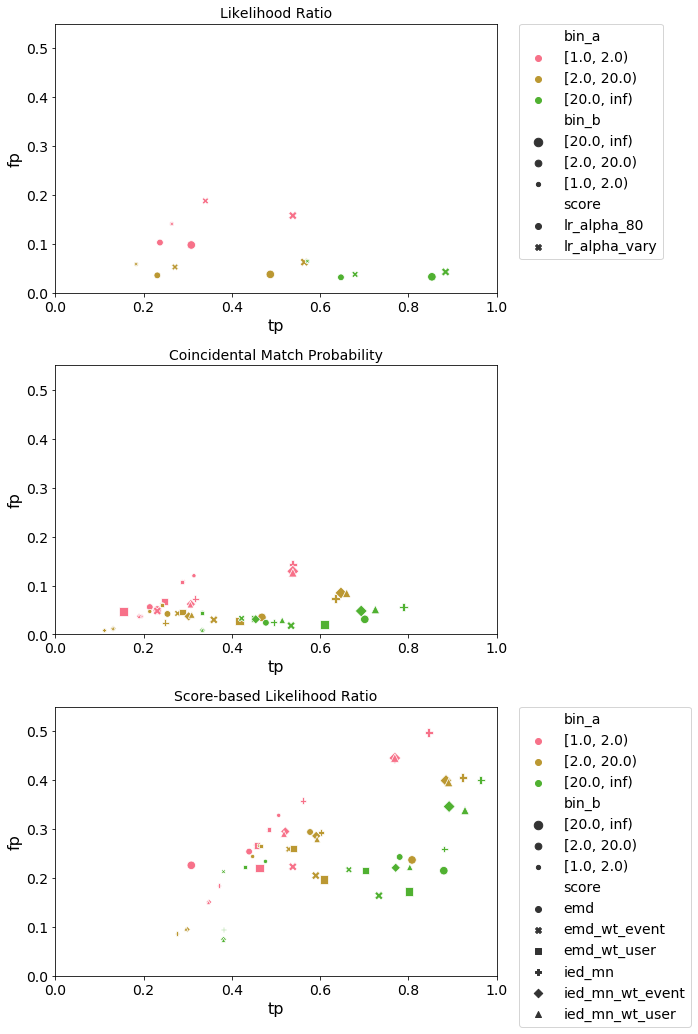

In [33]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sns.set_palette("husl")
xlim = (0,1)
ylim = (0,0.55)

f, axes = plt.subplots(3, 1, figsize=(10,15))

sns.scatterplot(
    x='tp', 
    y='fp', 
    data=rslt.loc[rslt.method == 'lr'], 
    hue='bin_a', 
    style='score', 
    size='bin_b',
    size_order=list(reversed(rslt.bin_b.cat.categories)),
    ax=axes[0]
).set_title("Likelihood Ratio")
axes[0].set_ylim(ylim)
axes[0].set_xlim(xlim)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.scatterplot(
    x='tp', 
    y='fp', 
    data=rslt.loc[rslt.method == 'cmp'], 
    hue='bin_a', 
    style='score', 
    size='bin_b',
    size_order=list(reversed(rslt.bin_b.cat.categories)),
    ax=axes[1]
).set_title("Coincidental Match Probability")
axes[1].set_ylim(ylim)
axes[1].set_xlim(xlim)
axes[1].get_legend().remove()

sns.scatterplot(
    x='tp', 
    y='fp',
    data=rslt.loc[rslt.method == 'slr'],
    hue='bin_a', 
    style='score', 
    size='bin_b',
    size_order=list(reversed(rslt.bin_b.cat.categories)),
    ax=axes[2]
).set_title("Score-based Likelihood Ratio")
axes[2].set_ylim(ylim)
axes[2].set_xlim(xlim)
axes[2].get_legend().remove()

handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

### Simplify for DFRWS

In [34]:
sc = ['emd_wt_user', 'lr_alpha_80']
simple = rslt.loc[(rslt.bin_a == rslt.bin_b) & 
                  (rslt.score.isin(sc))]
simple['x'] = simple.bin_a.cat.codes
simple

,bin_a,bin_b,score,auc,tp,fp,method,x
77,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.624,0.287,0.107,cmp,0
1,"[1.0, 2.0)","[1.0, 2.0)",lr_alpha_80,0.602,0.264,0.141,lr,0
23,"[1.0, 2.0)","[1.0, 2.0)",emd_wt_user,0.623,0.484,0.299,slr,0
101,"[2.0, 20.0)","[2.0, 20.0)",emd_wt_user,0.683,0.288,0.046,cmp,1
9,"[2.0, 20.0)","[2.0, 20.0)",lr_alpha_80,0.641,0.231,0.036,lr,1
47,"[2.0, 20.0)","[2.0, 20.0)",emd_wt_user,0.681,0.540,0.260,slr,1
125,"[20.0, inf)","[20.0, inf)",emd_wt_user,0.884,0.610,0.020,cmp,2
17,"[20.0, inf)","[20.0, inf)",lr_alpha_80,0.972,0.853,0.033,lr,2
71,"[20.0, inf)","[20.0, inf)",emd_wt_user,0.882,0.801,0.173,slr,2


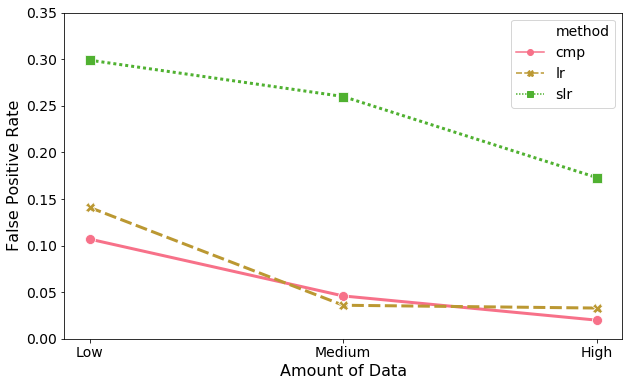

In [35]:
f, ax = plt.subplots(figsize=(10,6))

sns.lineplot(
    x='x', 
    y='fp',
    data=simple,
    hue='method',
    style='method',
    markers=True,
    markersize=10,
    linewidth=3
)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim((0,0.35))

plt.xticks([0,1,2])
plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

plt.show()

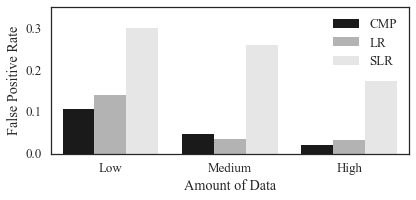

In [39]:
import matplotlib

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
#         [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        [0.9, 0.9, 0.9],          # light gray
    ])
        
        
def set_size(fig):
    fig.set_size_inches(6, 3)
    plt.tight_layout()

    
# sns.palplot(get_colors())

set_style()
sns.set_palette(get_colors())

f, ax = plt.subplots()

sns.barplot(
    x='x', 
    y='fp',
    data=simple,
    hue='method',
)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim((0,0.35))

legend = plt.legend()
legend.get_texts()[0].set_text('CMP')
legend.get_texts()[1].set_text('LR')
legend.get_texts()[2].set_text('SLR')

plt.xticks([0,1,2])
plt.xlabel('Amount of Data')
plt.ylabel('False Positive Rate')

set_size(f)

plt.show()